# Pair Optimization

Number of data points in file =  210
GLD-GDX:  0.499
GLD-SLV:  0.533


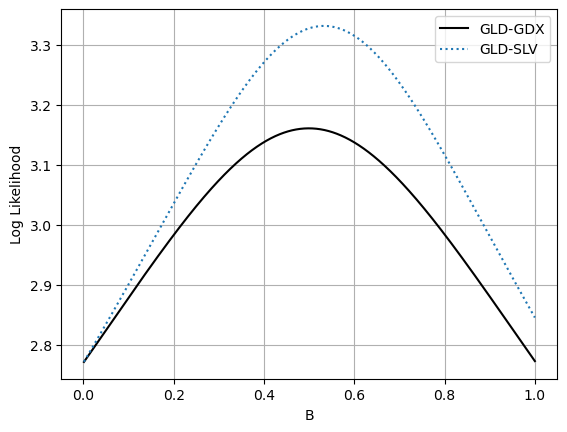

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# Ornstein-Uhlenbeck process is not just stationary but also normally distributed
# ou parameter : dXt = mu(theta - Xt)dt + sigma * dBt
#      - Bt : standard Brownian motion under the probability measure P
#      - mu : deterministic part & the drift of the process, mean-reversion rate
#      - sigma : control the random process 
#      - θ : long-term mean, θ ∈ R
#      - If sigma is large enough, then mu become unsignificant for the process


# Source of Mathmatical Calculation
# https://www.ubs.com/global/en/investment-bank/in-focus/research-focus/quant-answers/quant-insight-series/_jcr_content/mainpar/toplevelgrid_7262680_322968126/col1/actionbutton_3358030.1305440028.file/PS9jb250ZW50L2RhbS9pbnRlcm5ldGhvc3RpbmcvaW52ZXN0bWVudGJhbmsvZW4vZXF1aXRpZXMvcWlzLXZpcnR1YWwtZXZlbnQtZGVja3MtMjAyMC9tci10cmFkaW5nLXRhbGstdWJzLWFwcmlsLTIwMjEucGRm/mr-trading-talk-ubs-april-2021.pdf
# https://github.com/mghadam/ouparams/blob/main/src/ouparams/ouparams.py
# https://reference.wolfram.com/language/ref/OrnsteinUhlenbeckProcess.html

def get_optimal_ou_params(X, dt): 
    """
    Xx = Σ(i=1, i=n) x(i-1)
    Xy = Σ(i=1, i=n) x(i)
    Xxx = Σ(i=1, i=n) x(i-1)^2
    Xyy = Σ(i=1, i=n) x(i)^2
    Xxy = Σ(i=1, i=n) x(i) * x(i-1)
    """
    n = X.size
    Xx  = np.sum(X[:-1])
    Xy  = np.sum(X[1:])
    Xxx = np.sum(X[:-1]**2)
    Xyy = np.sum(X[1:]**2)
    Xxy = np.sum(X[:-1] * X[1:])
        
    theta_star = ((Xy * Xxx) - (Xx * Xxy))/(n*(Xxx - Xxy) - ((Xx**2) - Xx * Xy)) # Mean
    mu_star = -(1 / dt) * np.log((Xxy - theta_star * Xx - theta_star * Xy + n*theta_star**2)/(Xxx - 2 * theta_star * Xx + n * theta_star**2))    
    alpha = np.exp(-mu_star * dt) # Rate
    sigma_h = np.sqrt((1/n)*(Xyy-(2*alpha*Xxy)+((alpha**2)*Xxx)-(2*theta_star*(1-alpha)*(Xy-alpha*Xx))+(n*(theta_star**2)*(1-alpha)**2)))
    sigma_star = np.sqrt((sigma_h**2)*(2*mu_star/(1-alpha**2)))  # Volatility

    return theta_star, mu_star, sigma_star


"""Inaccurate Result
def fit_ar1(ts: pd.Series, dt:float = 1/252) -> (np.array, float):
    
    # Fit AR(1) process from time series of price
    
    ts_y = ts.values[1:].reshape(-1, 1)
    ts_x = np.append(np.ones(len(ts_y)), ts.values[:-1]).reshape(2,-1).T
    
    phi = np.linalg.inv(ts_x.T @ ts_x) @ ts_x.T @ ts_y
    sigma = np.sqrt(np.sum((ts_y - ts_x @ phi) ** 2) / (len(ts_y)))
    phi = phi.reshape(-1)
    
    theta = phi[0] / (1-phi[1])
    mu = (1-phi[1]) / dt
    sigma = sigma / np.sqrt(dt)
    return theta, mu, sigma
"""


def get_average_log_likelihood(theta, mu, sigma, X, dt):
    sigma_square = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    sigma_tilda = np.sqrt( sigma_square )
    
    N = X.size
    
    term1 = -0.5 * np.log(2 * np.pi)
    term2 = -np.log(sigma_tilda)
    
    prefactor = -1 / (2 * N * sigma_tilda**2)
    sum_term = 0
    for i in range(1, N):
        x2 = X[i]
        x1 = X[i-1]
        
        sum_term = sum_term + (x2 - x1 * np.exp(-mu*dt) - \
                   theta * (1-np.exp(-mu*dt)))**2
    
    f = (term1 + term2 + prefactor * sum_term)
    return f


def compose_xt(s1, s2, A, B):
    alpha = A / s1[0]
    beta = B / s2[0]
    return alpha * s1 - beta * s2


def get_mle_table(s1, s2, dt):

    candidate_B = np.linspace(0.001, 1, 1000)
    optimal_params_table = []
    for B in candidate_B:
        X = compose_xt(s1, s2, 1, B)
        theta_star, mu_star, sigma_star = get_optimal_ou_params(X, dt)
        mle = get_average_log_likelihood(theta_star, mu_star, sigma_star, X, dt)
        optimal_params_table.append((theta_star, mu_star, sigma_star, mle, B))

    table = pd.DataFrame(optimal_params_table, columns=['theta', 'mu', 'sigma', 'mle', 'B'])
    return table


def get_B_star(table):
    return float(table.iloc[np.where(table.mle==np.max(table.mle))].B.values)

 
if __name__ == "__main__":
    # Same example 
    GDX = pd.read_csv('data/GDX_historical.csv')
    GLD = pd.read_csv('data/GLD_historical.csv')
    SLV = pd.read_csv('data/SLV_historical.csv')

    gld = GLD['Adj Close'].to_numpy()
    gdx = GDX['Close'].to_numpy()
    slv = SLV['Close'].to_numpy()

    print('Number of data points in file = ', gld.size)

    #  The book uses only 200 points, so we'll trim our data down.
    #  I wrote this so you can easily adjust which 200 points are used.
    #  Obviously, don't go beound the length of the raw data.

    M = 3
    gld = gld[M:M + 200]
    gdx = gdx[M:M + 200]
    slv = slv[M:M + 200]

    N = gld.size
    dt = 1/252

    table1 = get_mle_table(gld, gdx, dt)
    table2 = get_mle_table(gld, slv, dt)

    B = np.linspace(0.001, 1, 1000)
    plt.plot(B, table1.mle, 'k', label = 'GLD-GDX')
    plt.plot(B, table2.mle, ':', label = 'GLD-SLV')
    plt.xlabel('B')
    plt.ylabel('Log Likelihood')
    plt.grid()
    plt.legend()

    B_star_gld_gdx = get_B_star(table1)
    B_star_gld_slv = get_B_star(table2)

    print('GLD-GDX: ', B_star_gld_gdx )
    print('GLD-SLV: ', B_star_gld_slv )

In [2]:
xt = compose_xt(gld, gdx, 1, B_star_gld_gdx)
x2t = compose_xt(gld, slv, 1, B_star_gld_slv)

theta, mu, sigma = get_optimal_ou_params(xt, dt=1/252)
theta2, mu2, sigma2 = get_optimal_ou_params(x2t, dt=1/252)

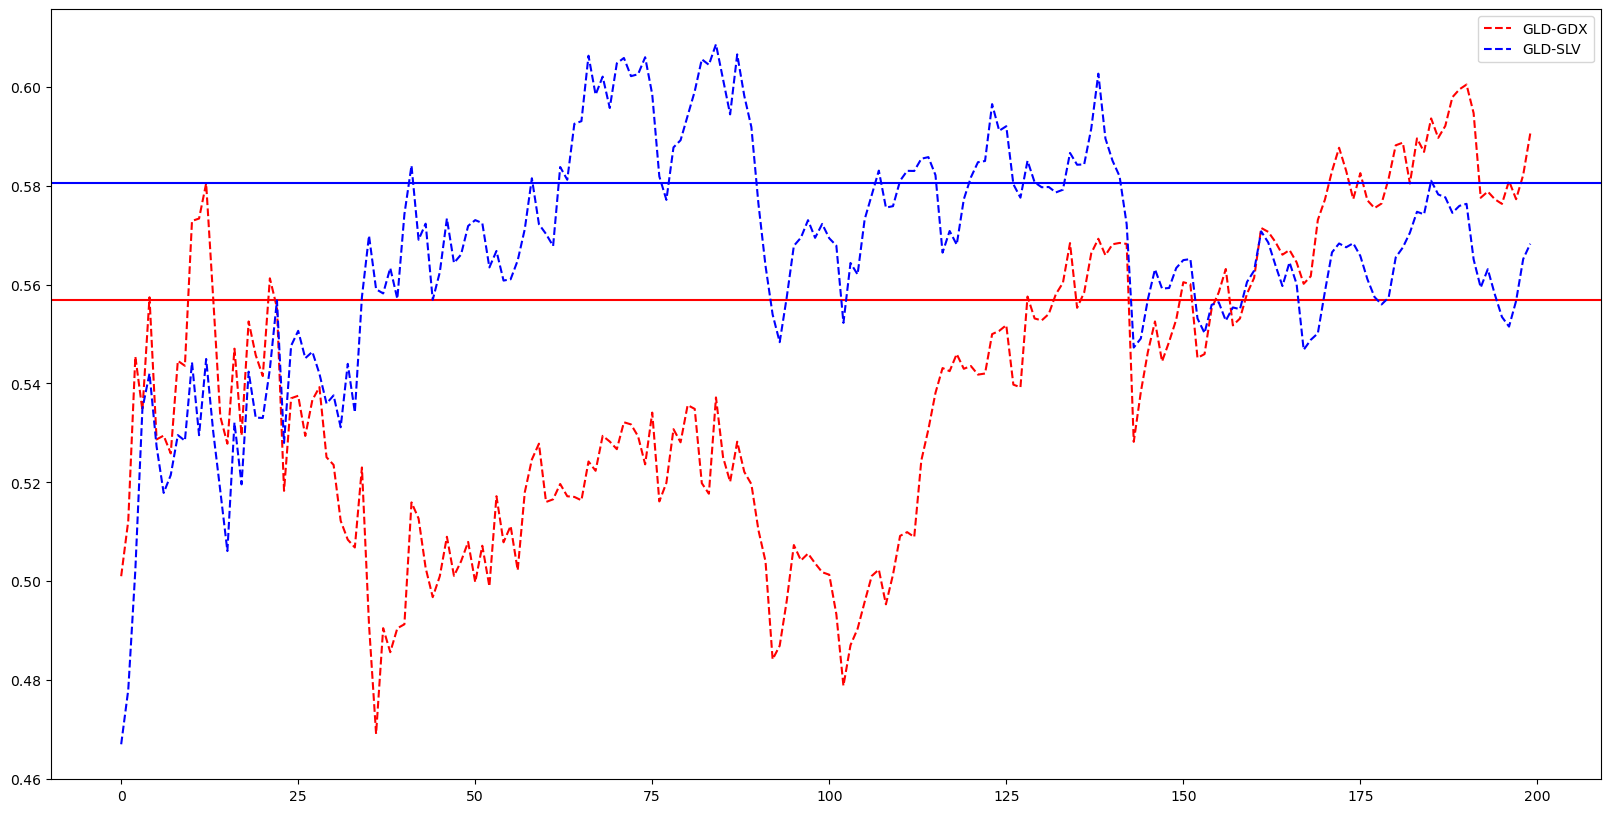

In [3]:
plt.figure(figsize=(20, 10))
plt.plot(xt,'--', label='GLD-GDX', color='r')
plt.axhline(theta, color = 'r')
# plt.axhline(np.mean(xt))
plt.plot(x2t,'--', label='GLD-SLV', color='b')
plt.axhline(theta2, color='b')
# plt.axhline(np.mean(x2t))
plt.legend()

# Solution

In [4]:
from ou_process import *

import numpy as np
from scipy.integrate import quad
from typing import Callable

import matplotlib.pyplot as plt


def function_F(mu: np.float32,
               sigma: np.float32,
               theta: np.float32,
               r: np.float32) -> Callable[np.float32, np.float32]:
    
    def f(u, x):
        term1 = u**(r/mu - 1)
        term2 = np.exp( (np.sqrt(2*mu/(sigma**2))) * (x-theta) * u - (u**2)/2 )
        return term1 * term2
    
    def F(x):
        return quad(f, 0, np.inf, args=(x,))[0]

    return F
    

def function_F_prime(mu: np.float32,
                     sigma: np.float32,
                     theta: np.float32,
                     r: np.float32) -> Callable[np.float32, np.float32]:
    
    def f_prime(u, x):
        term1 = u**(r/mu)
        term2 = np.exp( np.sqrt(2*mu/(sigma**2)) * (x-theta) * u - (u**2)/2 )
        return term1 * term2
    
    
    def F_prime(x):
        term3 = np.sqrt(2*mu/(sigma**2))
        return term3 * quad(f_prime, 0, np.inf, args=(x,))[0]
    
    return F_prime
    


def function_G(mu: np.float32,
               sigma: np.float32,
               theta: np.float32,
               r: np.float32) -> Callable[np.float32, np.float32]:
    
    def g(u, x):
        term1 = u**(r/mu - 1)
        term2 = np.exp( (np.sqrt(2*mu/(sigma**2))) * (theta-x) * u - (u**2)/2 )
        return term1 * term2
    
    def G(x):
        return quad(g, 0, np.inf, args=(x,))[0]

    return G

    
    
def function_G_prime(mu: np.float32,
                     sigma: np.float32,
                     theta: np.float32,
                     r: np.float32) -> Callable[np.float32, np.float32]:
    
    def g_prime(u, x):
        term1 = u**(r/mu)
        term2 = np.exp( np.sqrt(2*mu/(sigma**2)) * (theta-x) * u - (u**2)/2 )
        return term1 * term2
    
    def G_prime(x):
        term3 = np.sqrt(2*mu/(sigma**2))
        return term3 * quad(g_prime, 0, np.inf, args=(x,))[0]
    
    return G_prime


def expected_discounted_factor(mu: np.float32,
                                sigma: np.float32,
                                theta: np.float32,
                                r: np.float32,
                                x, 
                                kappa):
    """
    E[e^(-r*tauk)]
    """

    F = function_F(mu=mu, sigma=sigma, theta=theta, r=r)
    G = function_G(mu=mu, sigma=sigma, theta=theta, r=r)

    if x > kappa or x == kappa:
        return G(x)/G(kappa)

    elif x < kappa:
        return F(x)/F(kappa)


def psi(mu: np.float32,
        sigma: np.float32,
        theta: np.float32,
        r: np.float32,
        x):

    F = function_F(mu=mu, sigma=sigma, theta=theta, r=r)
    G = function_G(mu=mu, sigma=sigma, theta=theta, r=r)
    return F(x)/G(x)

In [5]:
def function_V(b : np.float32,
               c : np.float32, 
               F : Callable[np.float32, np.float32]) -> Callable[np.float32, np.float32]:
    
    """Input b should be b_star"""
    
    def V(x:np.float32) -> Callable[np.float32, np.float32]:
        if x < b:
            return (b-c) * F(x) / F(b)

        else:
            return x-c
    
    return V

def function_V_prime(b: np.float32,
                     c: np.float32,
                     F: Callable[np.float32, np.float32],
                     F_prime: Callable[np.float32, np.float32]) -> Callable[np.float32, np.float32]:

    def V_prime(x): 
        if x < b:
            return (b - c) * F_prime(x) / F(b)
        else:
            return 1

    return V_prime


def function_J(d: np.float32,
               c: np.float32,
               G: Callable[np.float32, np.float32],
               V: Callable[np.float32, np.float32]) -> Callable[np.float32, np.float32]:
    
    def J(x: np.float32) -> Callable[np.float32, np.float32]:
        
        if x < d: 
            return V(x) - x - c
        else: 
            return (V(d) - d - c) * G(x) / G(d)
    
    return J


def find_b_star(x: np.float32,
                c: np.float32,
                F: Callable[np.float32, np.float32],
                domain: np.array) -> np.float32: 
    
    # Temporary implementation
    i_b_star = np.argmax([function_V(b=b, c=c, F=F)(x) for b in domain]) 
    b_star = domain[i_b_star]
    return b_star

    # Original implementation
    
    # def find_b_star(x, cost, F, F_prime, lr = 1/3):
    #     error = np.finfo(float).max
    #     while True:
    #         fb, fpb = F(x), F_prime(x)
    #         if fpb <=0:
    #             raise ValueError("F' is not > 0")
    #         error = (cost - x) * fpb +fb
    #         # print(f'{error} at {fb}, {fpb}, {x}')
    #         if abs(error) > 1e-14:
    #             x += lr * error/fpb
    #         else:
    #             break
    #     return x
    
def find_d_star(x: np.float32,
                c: np.float32,
                G: Callable[np.float32, np.float32],
                V: Callable[np.float32, np.float32],
                domain: np.array) -> np.float32: 
    
    # Temporary implementation
    i_d_star = np.argmax([function_J(d=d, c=c, G=G, V=V)(x) for d in domain]) 
    d_star = domain[i_d_star]
    return d_star

    # Original implementation

    # def find_d_star(x, cost, G, G_prime, V, V_prime, lr =1/100):
    #     error = np.finfo(float).max
    #     while True:
    #         g_temp, v_temp = G(x), V(x, cost) - x -cost
    #         gp, vp = G_prime(x), V_prime(x, cost) -1
    #         # if v_temp <=0:
    #         #     raise ValueError("V-b-c is not > 0")
    #         try:
    #             # error = gp/g_temp - vp/v_temp
    #             error = v_temp - g_temp
    #         except ZeroDivisionError:
    #             print(f'{x} with {error} = {v_temp} - {g_temp} and {gp}, {vp}')
    #         # print(f'{error} at {v_temp} - {g_temp}')
    #         if abs(error) > 1e-14:
    #             if vp > gp:
    #                 x += lr * error/vp
    #             else:
    #                 x -= lr * error/gp
    #         else:
    #             break
    #     return x

In [42]:
x = xt[0]
r = 0.05
c = 0.05
# r = 0.01
# c = 0.00015
# c_prime = 0.00265 # 매도 : 0.00015 + 세금 : 0.0025
theta = 0.5388
mu = 16.6677
sigma = 0.1599

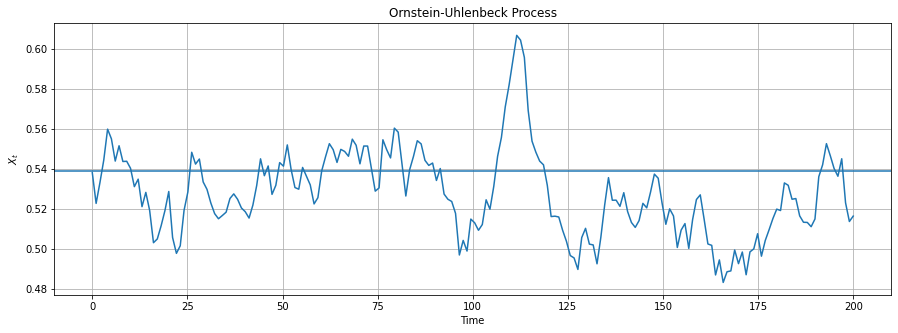

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize parameters and variables
theta = 0.5388
mu = 16.6677
sigma = 0.1599
T = 200       # Total time
dt = 1/252    # Time step
N = 200 # Number of time steps
X0 = 0.538     # Initial value

# Create time array and initialize X array
t = np.linspace(0, T, N)
X = np.zeros(N)
X[0] = X0

# Generate OU process using Euler-Maruyama method
# np.random.seed(0)  # for reproducibility
for i in range(1, N):
    dB = np.sqrt(dt) * np.random.normal()
    dX = mu * (theta - X[i-1]) * dt + sigma * dB
    X[i] = X[i-1] + dX

# Plot the OU process
plt.figure(figsize=(15, 5))
plt.plot(t, X)
plt.axhline(theta)
plt.xlabel('Time')
plt.ylabel('$X_t$')
plt.title('Ornstein-Uhlenbeck Process')
plt.grid(True)
plt.show()


### Finding candidate interval [a, b]

In [14]:
from scipy.optimize import minimize
import numpy as np
from typing import Tuple

def function_h(x, c):
    """Reward Function"""
    def h(x, c):
        return x-c
    return h


def test_expected_discounted_factor(x: np.float32, a: np.float32, b: np.float32, F, G):
    """
    test_expected_discounted_factor(a_star, b_star, a_star, F, G) # (1, 0)
    test_expected_discounted_factor(b_star, a_star, b_star, F, G) # (0, 1)
    """
    if x <= a:
        exp_a = F(x) / F(a)
        exp_b = 0  # As it's certain that tau_a < tau_b in this case
    elif x >= b:
        exp_a = 0  # As it's certain that tau_a > tau_b in this case
        exp_b = G(x) / G(b)
    else:
        exp_a = F(x) / F(a)
        exp_b = G(x) / G(b)
    return exp_a, exp_b


def expected_discounted_reward(params: Tuple[np.float32, np.float32], x: np.float32, h, F, G) -> np.float32:
    a, b = params
    
    if x <= a:
        exp_a = F(x) / F(a)
        exp_b = 0  # As it's certain that tau_a < tau_b in this case
    elif x >= b:
        exp_a = 0  # As it's certain that tau_a > tau_b in this case
        exp_b = G(x) / G(b)
    else:
        exp_a = F(x) / F(a)
        exp_b = G(x) / G(b)

    return -(h(a) * exp_a + h(b) * exp_b)


def find_optimal_interval(F,
                          G,
                          r: np.float32,
                          c: np.float32,
                          x: np.float32) -> Tuple[np.float32, np.float32]:
    
    h = lambda z: z - c

    # Optimize for a and b jointly
    initial_guess = [x - 0.1, x + 0.1]  # Replace with more educated guesses if available
    # initial_guess = [0.4690968492625811, 0.6004618825146063] # np.min(xt), np.max(xt)
    bounds = [(-np.inf, np.inf), (-np.inf, np.inf)]  # Replace with actual bounds if available
    
    result = minimize(expected_discounted_reward, initial_guess, args=(x, h, F, G), bounds=bounds)
    
    a_star, b_star = result.x
    
    return a_star, b_star

F = function_F(mu=mu, sigma=sigma, theta=theta, r=r)
F_prime = function_F_prime(mu=mu, sigma=sigma, theta=theta, r=r)
G = function_G(mu=mu, sigma=sigma, theta=theta, r=r)
G_prime = function_G_prime(mu=mu, sigma=sigma, theta=theta, r=r)


xt = compose_xt(gld, gdx, 1, B_star_gld_gdx)
x = xt[0]
theta, mu, sigma = get_optimal_ou_params(xt, dt=1/252)
r = 0.05
c = 0.05

a_star, b_star = find_optimal_interval(F,G, r, c, x)

print("Optimal Interval [a, b]:", "[{}, {}]".format(a_star, b_star))


C:\Users\joseongmin\AppData\Local\Temp\ipykernel_16896\2426853015.py:17: RuntimeWarning: overflow encountered in exp
  term2 = np.exp( (np.sqrt(2*mu/(sigma**2))) * (x-theta) * u - (u**2)/2 )
C:\Users\joseongmin\AppData\Local\Temp\ipykernel_16896\2426853015.py:21: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, 0, np.inf, args=(x,))[0]
C:\Users\joseongmin\AppData\Local\Temp\ipykernel_16896\2426853015.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated

Optimal Interval [a, b]: [0.5009898059508424, 0.712724325791035]


C:\Users\joseongmin\AppData\Local\Temp\ipykernel_16896\2426853015.py:17: RuntimeWarning: overflow encountered in exp
  term2 = np.exp( (np.sqrt(2*mu/(sigma**2))) * (x-theta) * u - (u**2)/2 )
C:\Users\joseongmin\AppData\Local\Temp\ipykernel_16896\2426853015.py:21: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(f, 0, np.inf, args=(x,))[0]
C:\Users\joseongmin\AppData\Local\Temp\ipykernel_16896\2426853015.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated

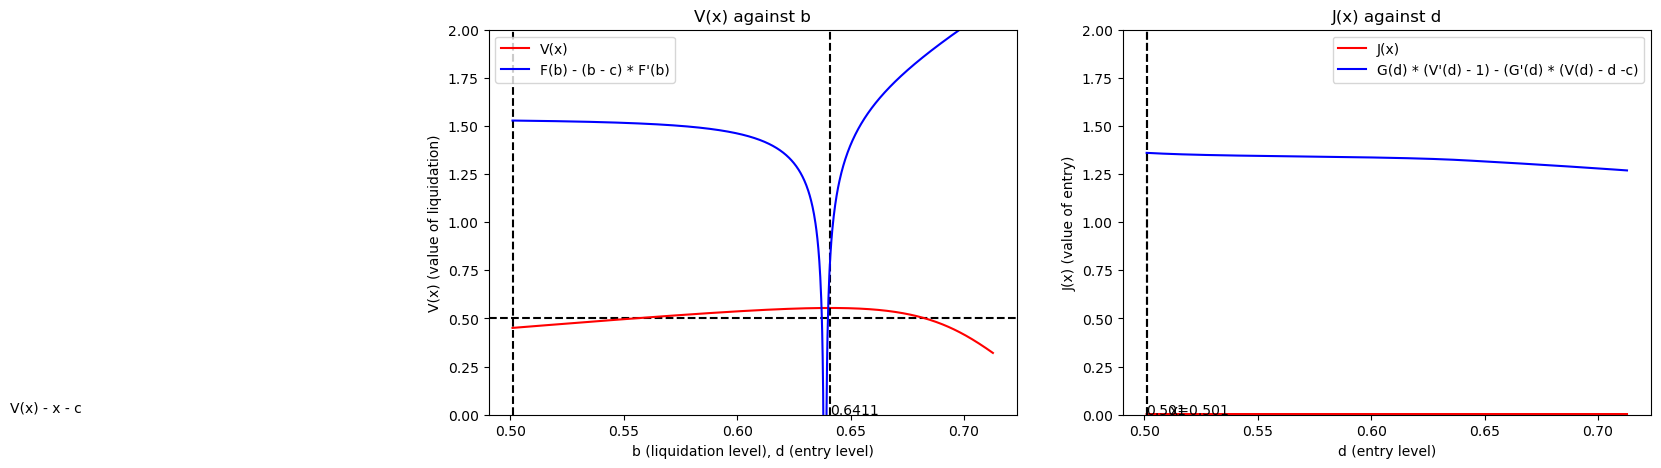

In [15]:
# Same example 
GDX = pd.read_csv('data/GDX_historical.csv')
GLD = pd.read_csv('data/GLD_historical.csv')
SLV = pd.read_csv('data/SLV_historical.csv')

gld = GLD['Adj Close'].to_numpy()
gdx = GDX['Close'].to_numpy()
slv = SLV['Close'].to_numpy()

M = 3
gld = gld[M:M + 200]
gdx = gdx[M:M + 200]
slv = slv[M:M + 200]

N = gld.size
dt = 1/252

table1 = get_mle_table(gld, gdx, dt)
table2 = get_mle_table(gld, slv, dt)

B = np.linspace(0.3, 1, 500)
B_star_gld_gdx = get_B_star(table1)
B_star_gld_slv = get_B_star(table2)

xt = compose_xt(gld, gdx, 1, B_star_gld_gdx)
theta, mu, sigma = get_optimal_ou_params(xt, dt=1/252)

xt = compose_xt(gld, gdx, 1, B_star_gld_gdx)
x = xt[0]
theta, mu, sigma = get_optimal_ou_params(xt, dt=1/252)
# theta = 0.5388
# mu = 16.6677
# sigma = 0.1599
r = 0.05
c = 0.05

F = function_F(mu=mu, sigma=sigma, theta=theta, r=r)
F_prime = function_F_prime(mu=mu, sigma=sigma, theta=theta, r=r)
G = function_G(mu=mu, sigma=sigma, theta=theta, r=r)
G_prime = function_G_prime(mu=mu, sigma=sigma, theta=theta, r=r)

candidate_a, candidate_b = find_optimal_interval(F, G, r, c, x)
# print("Optimal Interval [a, b]:", "[{}, {}]".format(candidate_a, candidate_b))

# plot V(x) against b
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("V(x) against b")
plt.xlabel("b (liquidation level), d (entry level)")
plt.ylabel("V(x) (value of liquidation)")
plt.ylim([0, 2])
plt.axvline(x=x, color='k', linestyle='--')
plt.axhline(y=x, color='k', linestyle='--')

domain = np.linspace(candidate_a, candidate_b, num=1000, endpoint=True)

l_V = plt.plot(domain, [function_V(b=b, c=c, F=F)(x) for b in domain], color='r', label="V(x)")

b_star = find_b_star(x=x, c=c, F=F, domain=domain)
plt.axvline(x=b_star, color='k', linestyle='--')
plt.text(b_star, 0 ,f"{b_star.round(4)}")
l_diff = plt.plot(domain,
                [np.log(np.log(abs(F(b_star) - (b_star - 0) * F_prime(b_star)))) for b_star in domain],  # to rescale
                color='b',
                label="F(b) - (b - c) * F'(b)")
plt.legend()

# plot J(x) against d
plt.subplot(1, 2, 2)
plt.title("J(x) against d")
plt.xlabel("d (entry level)")
plt.ylabel("J(x) (value of entry)")
plt.ylim([0, 2])
V = function_V(b=b_star, c=c, F=F)
V_prime = function_V(b=b_star, c=c, F=F)

plt.plot(domain,
        [function_J(d=d, c=c, G=G, V=V)(x) for d in domain],
        color='r',
        label="J(x)")
d_star = find_d_star(x=x, c=c, G=G, V=V, domain=domain)
plt.axvline(x=d_star, color='k', linestyle='--')
plt.text(d_star, 0 ,f"{d_star.round(4)}")
plt.axvline(x=x, color='k', linestyle='--')
plt.text(0, V(x) - x - c + 0.01 ,f"V(x) - x - c")
plt.text(x  + 0.01, 0,f"x={x}")
plt.plot(domain,
        [np.log(np.log(abs(G(d) * (V_prime(d) - 1) - (G_prime(d) * (V(d) - d -c))))) for d in domain], # to rescale
        color='b',
        label="G(d) * (V'(d) - 1) - (G'(d) * (V(d) - d -c)")
plt.legend()
plt.show()

In [17]:
print(candidate_a)
print(b_star)
print(candidate_b)
print(d_star)

0.5009898059508424
0.6410864201794383
0.712724325791035
0.5009898059508424


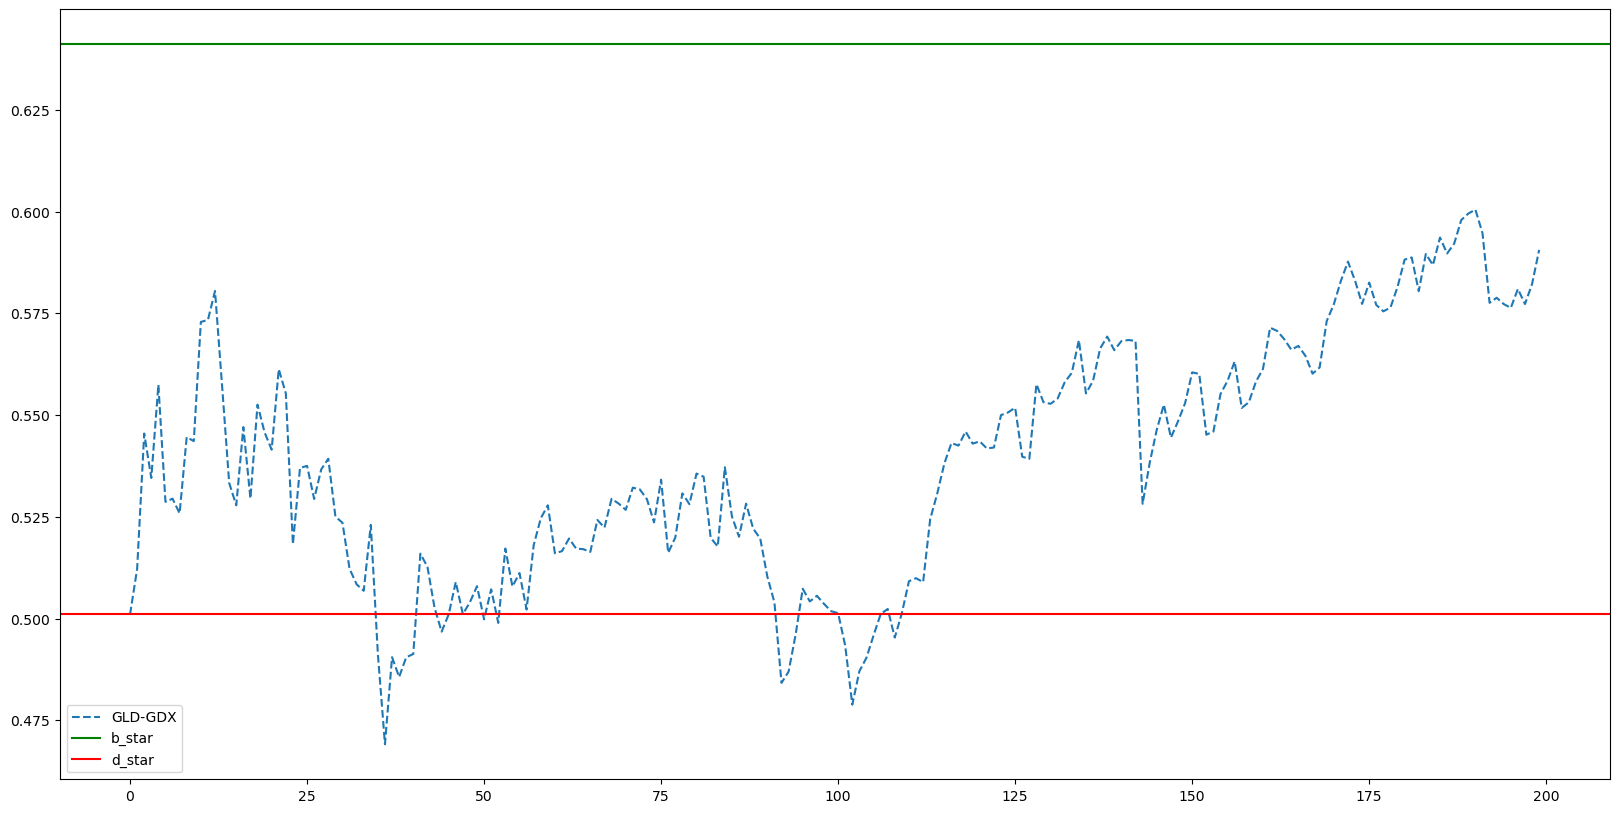

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(xt,'--', label='GLD-GDX')
plt.axhline(b_star, color = 'g', label='b_star')
plt.axhline(d_star, color = 'r', label='d_star')
plt.legend()

In [30]:
def strategy(X, mean, std_open=0.5, std_close=0.05, TC=0):
    """Implementation of the strategy.
        - std_open = levels for opening the position.
        - std_close = levels for closing the position.
        - TC = Transaction costs
    Returns:
        - status:  at each time says if we are long=1, short=-1 or we have no open positions = 0
        - cash: the cumulative amount of cash gained by the strategy.
        At terminal time if there is an open position, it is closed.
    """
    X0 = X[0]
    status = np.zeros_like(X)
    cash = np.zeros_like(X)
    cash[0] = X0
    for i, x in enumerate(X):
        if i == 0:
            continue
        if (status[i - 1] == 1) and (x >= mean - std_close):
            status[i] = 0
            cash[i] += x * (1 + TC)
        elif (status[i - 1] == -1) and (x <= mean + std_close):
            status[i] = 0
            cash[i] -= x * (1 + TC)
        elif (status[i - 1] == 0) and (x >= mean + std_open):
            status[i] = -1
            cash[i] += x * (1 + TC)
        elif (status[i - 1] == 0) and (x <= mean - std_open):
            status[i] = 1
            cash[i] -= x * (1 + TC)
        else:
            status[i] = status[i - 1]

    if status[-1] == 1:
        cash[-1] += x * (1 + TC)
    if status[-1] == -1:
        cash[-1] -= x * (1 + TC)

    return status, cash.cumsum()

In [31]:
strategy(xt, mean=theta)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.501, 0.501, 0.501, 0.501, 0.501, 0.501, 0.501, 0.501, 0.501,
        0.501, 0.501, 0.501, 0.

In [ ]:
mu - 